In [1]:
import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick

plt.rcParams["figure.figsize"] = (4.8, 3.2)
import urllib
import os
from tqdm.keras import TqdmCallback
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

from math import exp, sqrt, log, pi, sin, cos, atan, tan
import math
import cmath
from cmath import exp as cexp
from cmath import sqrt as csqrt
from cmath import log as clog
from cmath import phase as phase
from cmath import polar as polar

from functools import partial
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.model_selection import train_test_split

import scipy
from scipy import optimize, stats
from scipy.optimize import minimize

from random import gauss, uniform
from tqdm.notebook import tqdm

from scipy.special import gamma as gamma_func
import mpmath as mp  # with special hypergeometric functions
from scipy.special import hyp2f1 as hyp_2f1

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings

warnings.filterwarnings("ignore")  # to suppress warning messages
import itertools

## Simulate Option prices

In [2]:
def gen_bm_path(n_steps, N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    return w1

In [3]:
# Generate the paths for the Bergomi model with the given parameters
def path_generator(xi, kappa1, kappa2, eta1, eta2, rho, T, n_steps, N_sims, S0, w1, w2):
    dt = T / n_steps
    tt = np.linspace(0.0, T, n_steps + 1)

    # Simulate Xt1
    exp1 = np.exp(kappa1 * tt[1:])
    exp2 = np.exp(2 * kappa1 * tt)
    diff_exp2 = np.diff(exp2)
    std_vec = (
        eta1 * np.sqrt(diff_exp2 / (2 * kappa1))[:, np.newaxis]
    )  # to be broadcasted columnwise
    exp1 = exp1[:, np.newaxis]
    Xt1 = np.concatenate(
        (
            np.zeros(w1.shape[1])[np.newaxis, :],
            (1 / exp1) * np.cumsum(std_vec * w1, axis=0),
        )
    )

    # Simulate Xt2
    exp1_2 = np.exp(kappa2 * tt[1:])
    exp2_2 = np.exp(2 * kappa2 * tt)
    diff_exp2_2 = np.diff(exp2_2)
    std_vec_2 = (
        eta2 * np.sqrt(diff_exp2_2 / (2 * kappa2))[:, np.newaxis]
    )  # to be broadcasted columnwise
    exp1_2 = exp1_2[:, np.newaxis]
    Xt2 = np.concatenate(
        (
            np.zeros(w1.shape[1])[np.newaxis, :],
            (1 / exp1_2) * np.cumsum(std_vec_2 * w1, axis=0),
        )
    )

    Xt = Xt1 + Xt2

    # Simulate Vt
    drift_1 = eta1**2 * (1 - np.exp(-2 * kappa1 * tt)) / (2 * kappa1)
    drift_2 = eta2**2 * (1 - np.exp(-2 * kappa2 * tt)) / (2 * kappa2)
    drift = (
        drift_1
        + drift_2
        + 2 * eta1 * eta2 * (1 - np.exp(-(kappa1 + kappa2) * tt)) / (kappa1 + kappa2)
    )
    Vt = xi * np.exp(Xt - 0.5 * drift[:, np.newaxis])

    # Simulate St
    log_S = np.ones(N_sims).reshape(1, -1) * log(S0)
    # epochs_iter_j = tqdm(range(n_steps), desc="iteration", miniters=2000)
    for j in range(n_steps):
        log_S_next = (
            log_S[j]
            - 0.5 * Vt[j] * dt
            + np.sqrt(Vt[j] * dt) * (rho * w1[j] + sqrt(1 - rho**2) * w2[j])
        )
        log_S = np.append(log_S, log_S_next.reshape(1, -1), axis=0)

    S = np.exp(log_S)
    return S

In [9]:
def simulation(
    w1,
    w2,
    n_steps: int = 1000,
    N_sims: int = 1000,
    n_paths: int = 10,
) -> np.ndarray:

    simulation_data = []

    S0 = 100
    T = 2
    S = np.zeros((n_steps + 1, N_sims))

    # Define the strikes relative to S0
    strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]) * S0
    maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

    for i in range(n_paths):
        option_prices = np.zeros((len(strikes), len(maturities)))
        xi = np.random.uniform(0.03, 0.25)
        kappa1 = np.random.uniform(10, 60)
        kappa2 = 2.6
        eta1 = np.random.uniform(5, 35)
        eta2 = np.random.uniform(1, 5)
        rho = np.random.uniform(-0.9, -0.1)

        S = path_generator(
            xi, kappa1, kappa2, eta1, eta2, rho, T, n_steps, N_sims, S0, w1, w2
        )
        option_prices = np.array(
            [
                np.mean(
                    np.maximum(
                        0,
                        (S[int(maturity / T * n_steps), :][None, :] - strikes[:, None]),
                    ),
                    axis=1,
                )
                for maturity in maturities
            ]
        )
        params = np.array([xi, kappa1, eta1, eta2, rho])
        simulation_data.append(np.append(params, option_prices.flatten()))
    simulation_data = np.array(simulation_data)
    return simulation_data

# Sanity Check to see if simulated option prices seem to make sense

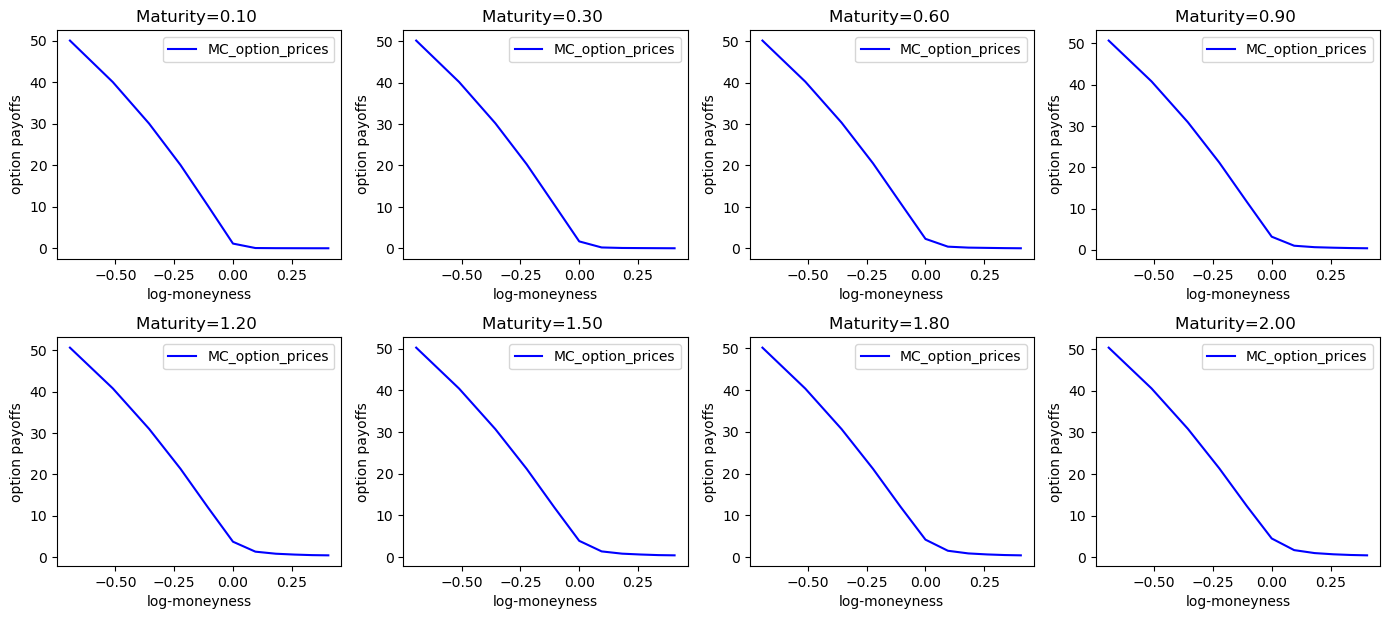

In [29]:
n_steps = 1000
N_sims = 1000
n_paths = 1

np.random.seed(351)
w1 = gen_bm_path(n_steps, N_sims)
np.random.seed(42)
w2 = gen_bm_path(n_steps, N_sims)

dat1 = simulation(w1, w2, n_steps, N_sims, n_paths)
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])
plt.figure(1, figsize=(14, 12))
for i in range(8):
    plt.subplot(4, 4, i + 1)

    plt.plot(
        np.log(strikes),
        dat1[0, 5:][i * 11 : (i + 1) * 11],
        "b",
        label="MC_option_prices",
    )

    plt.title("Maturity=%1.2f " % maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("option payoffs")

    plt.legend()
plt.tight_layout()
plt.show()

# Generate the training data for the neural network

In [27]:
from joblib import Parallel, delayed
import os

path = os.path.abspath(os.getcwd())
n_steps = 1000
N_sims = 1000
n_paths = 125

np.random.seed(351)
w1 = gen_bm_path(n_steps, N_sims)
np.random.seed(42)
w2 = gen_bm_path(n_steps, N_sims)

for i in range(100):  # 100 simulations of 10,000 paths each
    np_values = []
    for _ in range(10):  # save every 10,000 simulations
        executor = Parallel(n_jobs=8)
        tasks = (
            delayed(simulation)(w1, w2, n_steps, N_sims, n_paths) for _ in range(8)
        )
        values = executor(tasks)
        values = np.array(values).reshape(-1, 93)
        np_values.append(values)
    np_values = np.array(np_values).reshape(-1, 93)
    print(f"saving simulation_data_{i}.npy")
    np.save(
        f"/Users/aadhar/Downloads/DEEP_FIN_PROJ_1/data_same_brownian/simulation_data_{i}.npy",
        np_values,
    )

saving simulation_data_0.npy
saving simulation_data_1.npy
saving simulation_data_2.npy
saving simulation_data_3.npy
saving simulation_data_4.npy
saving simulation_data_5.npy
saving simulation_data_6.npy
saving simulation_data_7.npy
saving simulation_data_8.npy
saving simulation_data_9.npy
saving simulation_data_10.npy
saving simulation_data_11.npy
saving simulation_data_12.npy
saving simulation_data_13.npy
saving simulation_data_14.npy
saving simulation_data_15.npy
saving simulation_data_16.npy
saving simulation_data_17.npy
saving simulation_data_18.npy
saving simulation_data_19.npy
saving simulation_data_20.npy
saving simulation_data_21.npy
saving simulation_data_22.npy
saving simulation_data_23.npy
saving simulation_data_24.npy
saving simulation_data_25.npy
saving simulation_data_26.npy


KeyboardInterrupt: 

# PLAYGROUND for testing the stock simulations to see if the data is bad or ok

### Regular Use

In [453]:
from time import time

n_steps = 10000
N_sims = 100

simulation_data = []

S0 = 100
T = 2

dt = T / n_steps
tt = np.linspace(0.0, T, n_steps + 1)

S = np.zeros((n_steps + 1, N_sims))

np.random.seed(351)
w1 = gen_bm_path(n_steps, N_sims)
np.random.seed(42)
w2 = gen_bm_path(n_steps, N_sims)

# Define the strikes relative to S0
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]) * S0
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

start = time()
option_prices = np.zeros((len(maturities), len(strikes)))
xi = np.random.uniform(0.03, 0.25)
kappa1 = np.random.uniform(10, 60)
kappa2 = 2.6
eta1 = np.random.uniform(5, 35)
eta2 = np.random.uniform(1, 5)
rho = np.random.uniform(-0.9, -0.1)
print(f"xi: {xi}, kappa1: {kappa1}, eta1: {eta1}, eta2: {eta2}, rho: {rho}")

S = path_generator(xi, kappa1, kappa2, eta1, eta2, rho, T, n_steps, N_sims, S0, w1, w2)
option_prices = np.array(
    [
        np.mean(
            np.maximum(
                0, (S[int(maturity / T * n_steps), :][None, :] - strikes[:, None])
            ),
            axis=1,
        )
        for maturity in maturities
    ]
)
params = np.array([xi, kappa1, kappa2, eta1, eta2, rho])
simulation_data.append(np.append(params, option_prices.flatten()))

end = time()
simulation_data = np.array(simulation_data)
print(f"Simulation took {end-start:.2f} seconds.")

xi: 0.15709608571935035, kappa1: 43.18486463614794, eta1: 10.686958767584931, eta2: 3.44005670661135, rho: -0.21064416988674173
Simulation took 1.51 seconds.


In [ ]:
for maturity in maturities:
    for strike in strikes:
        print(
            f"{maturity=}, {strike=:.2f}, payoff=",
            np.maximum(0, (S[int(maturity / T * n_steps), :] - strike)).mean(),
        )

maturity=0.1, strike=50.00, payoff= 50.000094655533225
maturity=0.1, strike=60.00, payoff= 40.00711939650285
maturity=0.1, strike=70.00, payoff= 30.02373200954667
maturity=0.1, strike=80.00, payoff= 20.0697347966762
maturity=0.1, strike=90.00, payoff= 10.24976219961516
maturity=0.1, strike=100.00, payoff= 1.9953788813434317
maturity=0.1, strike=110.00, payoff= 0.18825785752912957
maturity=0.1, strike=120.00, payoff= 0.06594414762726072
maturity=0.1, strike=130.00, payoff= 0.03360454817787992
maturity=0.1, strike=140.00, payoff= 0.020444759338608332
maturity=0.1, strike=150.00, payoff= 0.014367279373461137
maturity=0.3, strike=50.00, payoff= 50.00792327744189
maturity=0.3, strike=60.00, payoff= 40.048840462874466
maturity=0.3, strike=70.00, payoff= 30.128705970522933
maturity=0.3, strike=80.00, payoff= 20.303388366219234
maturity=0.3, strike=90.00, payoff= 10.786178464321194
maturity=0.3, strike=100.00, payoff= 3.0166653465742157
maturity=0.3, strike=110.00, payoff= 0.6521871584486773
m

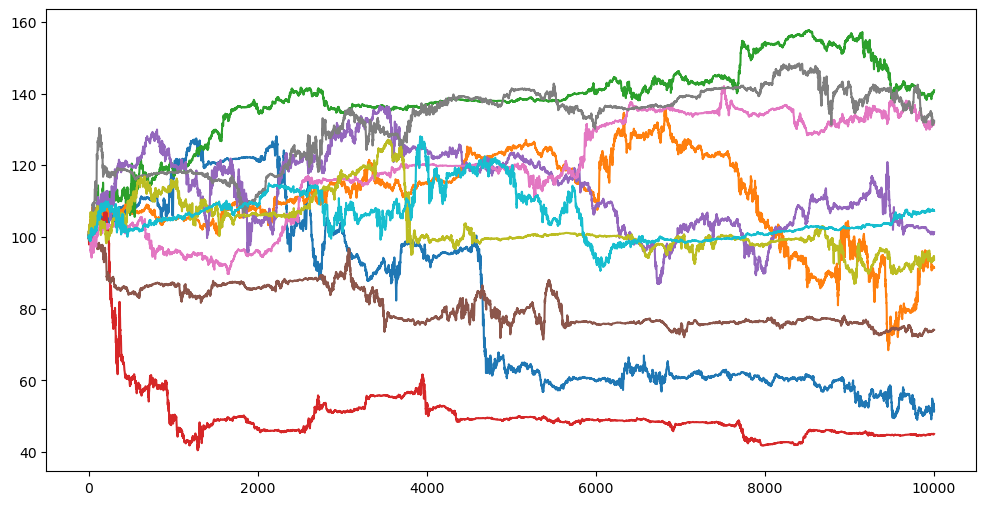

In [454]:
plt.figure(figsize=(12, 6))
plt.plot(S[:, :10])

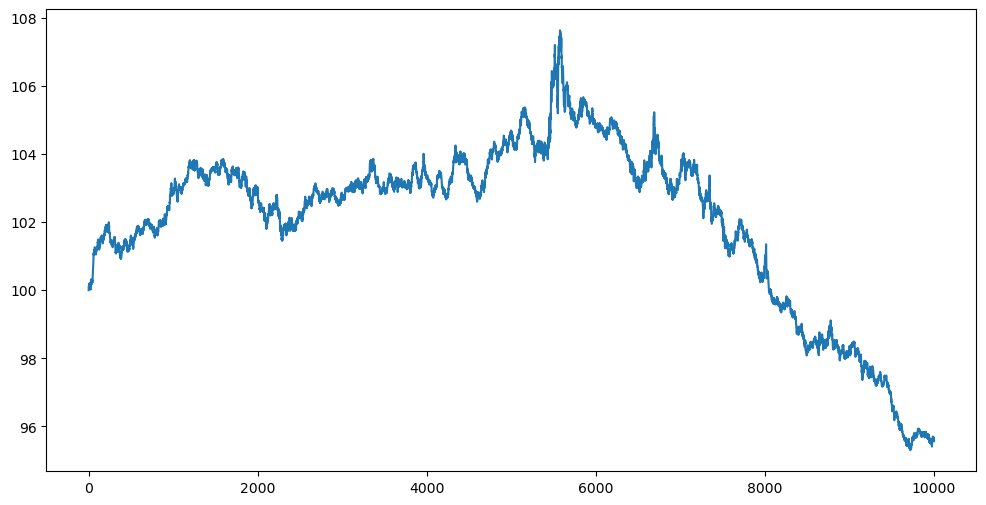

In [455]:
plt.figure(figsize=(12, 6))
plt.plot(S.mean(axis=1))

### Doing many different runs with the same parameters and comparing the ouputs to see variance of results

In [32]:
n_steps = 1000
N_sims = 100
xi = 0.04242795272361997
kappa1 = 14.320951903656816
kappa2 = 2.6
eta1 = 12.929120937456842
eta2 = 1.1057775029851036
rho = -0.26367567828035854
np.random.seed(351)
w1 = gen_bm_path(n_steps, N_sims)
np.random.seed(42)
w2 = gen_bm_path(n_steps, N_sims)
sims = []
for _ in range(100):
    S = path_generator(
        xi, kappa1, kappa2, eta1, eta2, rho, T, n_steps, N_sims, S0, w1, w2
    )
    sims.append(S.mean(axis=1))
sims = np.array(sims)
plt.figure(figsize=(12, 6))
plt.title("100 different random paths for stock price with same parameters")
plt.plot(sims)

NameError: name 'T' is not defined

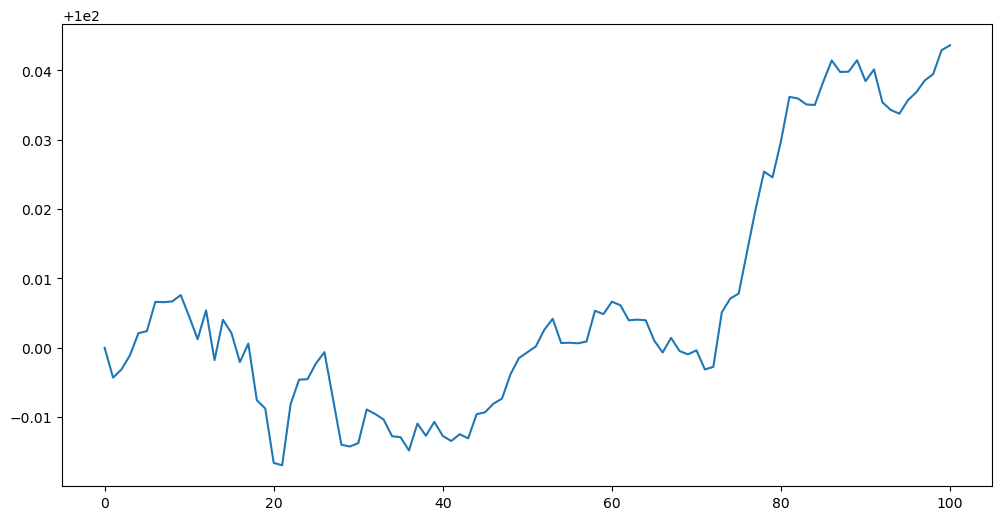

In [431]:
plt.figure(figsize=(12, 6))
plt.plot(sims.mean(axis=0))